In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.6/780.6 kB 13.0 MB/s eta 0:00:00a 0:00:01


In [2]:
import shutil
import os

# Đường dẫn nguồn và đích
input_path = "/kaggle/input"
working_path = "/kaggle/working"

# Tạo thư mục working nếu chưa có
os.makedirs(working_path, exist_ok=True)

# Sao chép toàn bộ thư mục từ input xuống working
for folder_name in os.listdir(input_path):
    full_input_path = os.path.join(input_path, folder_name)
    full_working_path = os.path.join(working_path, folder_name)
    if os.path.isdir(full_input_path):
        shutil.copytree(full_input_path, full_working_path)

In [3]:
import os
import random
import pandas as pd
from PIL import Image
import cv2
from ultralytics import YOLO
from IPython.display import Video
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import pathlib
import glob
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
image = cv2.imread("/kaggle/input/duy-data-pbl-4/Data_Lately/train/images/000000_jpg.rf.b11f308f16626f9f795a148029c46d10.jpg")
h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 416x416 and 3 channels.


In [5]:
import os
import matplotlib.pyplot as plt
def count_images(folder_path):
    files = os.listdir(folder_path)
    # Đếm số lượng file có định dạng hình ảnh (jpg, jpeg, png)
    image_count = sum(1 for file in files if file.lower().endswith(('jpg', 'jpeg', 'png', 'txt')))
    return image_count

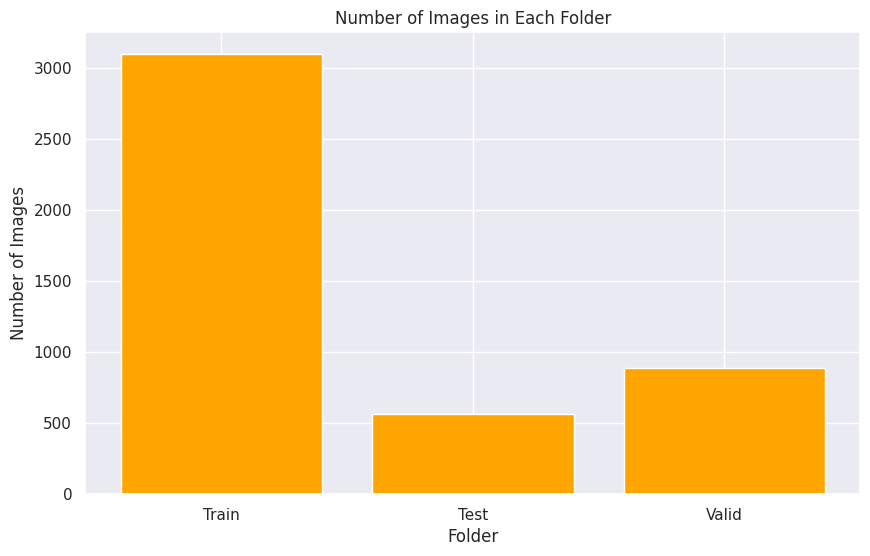

In [6]:
# Đường dẫn đến các thư mục
train_folder = '/kaggle/input/duy-data-pbl-4/Data_Lately/train/images'
test_folder = '/kaggle/input/duy-data-pbl-4/Data_Lately/test/images'
valid_folder = '/kaggle/input/duy-data-pbl-4/Data_Lately/valid/images'

# Đếm số lượng ảnh trong mỗi thư mục
train_count = count_images(train_folder)
test_count = count_images(test_folder)
valid_count = count_images(valid_folder)

# Dữ liệu để vẽ biểu đồ
folders = ['Train', 'Test', 'Valid']
image_counts = [train_count, test_count, valid_count]

# Tạo biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(folders, image_counts, color= "orange")
plt.xlabel('Folder')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Folder')
plt.show()

### **Augmentation**

In [7]:
import albumentations as A
from albumentations import BboxParams
from albumentations.core.composition import BboxParams

In [8]:
def load_image_and_label(image_path, label_path):
  image = cv2.imread(image_path)
  labels = []
  with open(label_path, "r") as f:
    for line in f.readlines():
      data = line.strip().split(" ")
      class_id = int(data[0])
      x_center, y_center, bbox_width, bbox_height = float(data[1]), float(data[2]), float(data[3]), float(data[4])
      labels.append((class_id, x_center, y_center, bbox_width, bbox_height))
  return image, labels

In [9]:
def apply_blur(image):
    return cv2.GaussianBlur(image, (15, 15), 0)

In [10]:
def augment_data(image_dir, label_dir, output_image_dir, output_label_dir, num_augmentations):
    # Define bbox_params with label_fields
    bbox_params = BboxParams(format='yolo', label_fields=['category_ids'])

    transformations = {
        #"hflip": A.HorizontalFlip(p=1),  # Example - Commented out as p=1 applies always
        "vflip": A.VerticalFlip(p=1),  # Example - Commented out as p=1 applies always
        "shift_scale_rotate": A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=1.0),
        "brightness_contrast": A.RandomBrightnessContrast(p=1),  # Example - Commented out as p=1 applies always
        # "rotate": A.Rotate(45),  # Example
        # "random_crop": A.RandomCrop(p=1),  # Example - Commented out as p=1 applies always
        #"Blur": A.Lambda
    }

    augmenter = A.Compose([transformations[name] for name in transformations], bbox_params=bbox_params)


    for filename in tqdm(os.listdir(image_dir)):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")
            image, labels = load_image_and_label(image_path, label_path)

            for i in range(num_augmentations):
                bbox_coords = [label[1:] for label in labels]
                category_ids = [label[0] for label in labels]
                # Adjust labels to include category_ids at the end of each bounding box definition
                augmented = augmenter(image=image, bboxes=bbox_coords, category_ids=category_ids)

                augmented_image = augmented['image']
                augmented_bbox_coords = augmented['bboxes']
                augmented_labels = [[category_ids[idx], *box] for idx, box in enumerate(augmented_bbox_coords)]
                # Get the applied transformation names
                applied_transformations = [name for name, func in transformations.items() if func in augmenter.transforms]

                # Create output filename with transformation names and augmentation count
                transformation_suffix = "_".join(applied_transformations)
                output_image_filename = f"{os.path.splitext(filename)[0]}_{transformation_suffix}_augmented_{i}.jpg"
                output_label_filename = f"{os.path.splitext(filename)[0]}_{transformation_suffix}_augmented_{i}.txt"

                # Save augmented image and labels
                cv2.imwrite(os.path.join(output_image_dir, output_image_filename), augmented_image)
                with open(os.path.join(output_label_dir, output_label_filename), "w") as f:
                    for label in augmented_labels:
                        f.write(f"{label[0]} {label[1]} {label[2]} {label[3]} {label[4]}\n")

In [11]:
if __name__ == "__main__":
  image_test_dir = "/kaggle/working/duy-data-pbl-4/Data_Lately/test/images"  
  label_test_dir = "/kaggle/working/duy-data-pbl-4/Data_Lately/test/labels"
  output_test_image_dir = "/kaggle/working/duy-data-pbl-4/Data_Lately/test/images" 
  output_test_label_dir = "/kaggle/working/duy-data-pbl-4/Data_Lately/test/labels" 
    
  image_valid_dir = "/kaggle/working/duy-data-pbl-4/Data_Lately/valid/images"  
  label_valid_dir = "/kaggle/working/duy-data-pbl-4/Data_Lately/valid/labels"
  output_valid_image_dir = "/kaggle/working/duy-data-pbl-4/Data_Lately/valid/images" 
  output_valid_label_dir = "/kaggle/working/duy-data-pbl-4/Data_Lately/valid/labels"
    
  image_train_dir = "/kaggle/working/duy-data-pbl-4/Data_Lately/train/images"  
  label_train_dir = "/kaggle/working/duy-data-pbl-4/Data_Lately/train/labels"
  output_train_image_dir = "/kaggle/working/duy-data-pbl-4/Data_Lately/train/images" 
  output_train_label_dir = "/kaggle/working/duy-data-pbl-4/Data_Lately/train/labels"
    
  num_augmentations = 5

  try:
        augment_data(image_test_dir, label_test_dir, output_test_image_dir, output_test_label_dir, num_augmentations)
        augment_data(image_valid_dir, label_valid_dir, output_valid_image_dir, output_valid_label_dir, num_augmentations)
        augment_data(image_train_dir, label_train_dir, output_train_image_dir, output_train_label_dir, num_augmentations)
        print(f"Successfully created {num_augmentations * len(os.listdir(image_train_dir))} augmented images.")
  except Exception as e:
        print(f"An error occurred: {e}")

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/890 [00:00<?, ?it/s]

  0%|          | 0/3099 [00:00<?, ?it/s]

Successfully created 92970 augmented images.


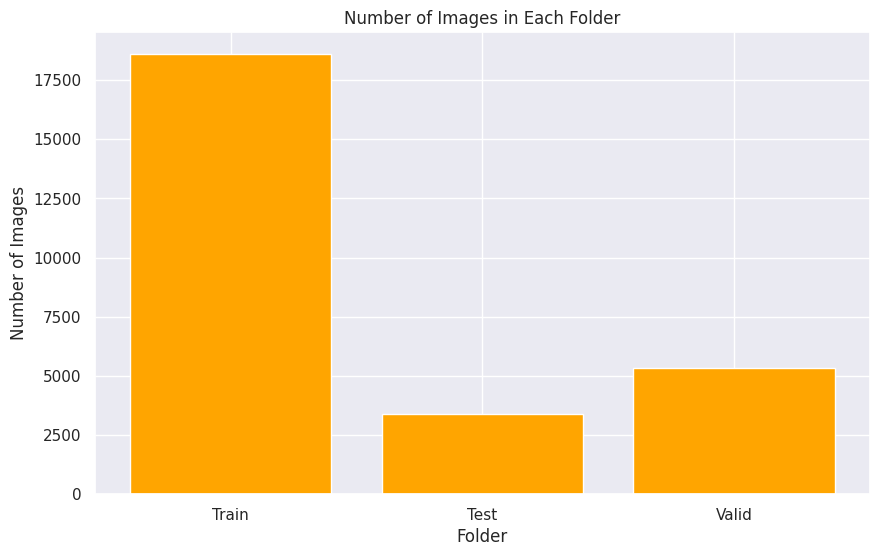

In [12]:
train_folder = '/kaggle/working/duy-data-pbl-4/Data_Lately/train/images'
test_folder = '/kaggle/working/duy-data-pbl-4/Data_Lately/test/images'
valid_folder = '/kaggle/working/duy-data-pbl-4/Data_Lately/valid/images'

# Đếm số lượng ảnh trong mỗi thư mục
train_count = count_images(train_folder)
test_count = count_images(test_folder)
valid_count = count_images(valid_folder)

# Dữ liệu để vẽ biểu đồ
folders = ['Train', 'Test', 'Valid']
image_counts = [train_count, test_count, valid_count]

# Tạo biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(folders, image_counts, color= "orange")
plt.xlabel('Folder')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Folder')
plt.show()

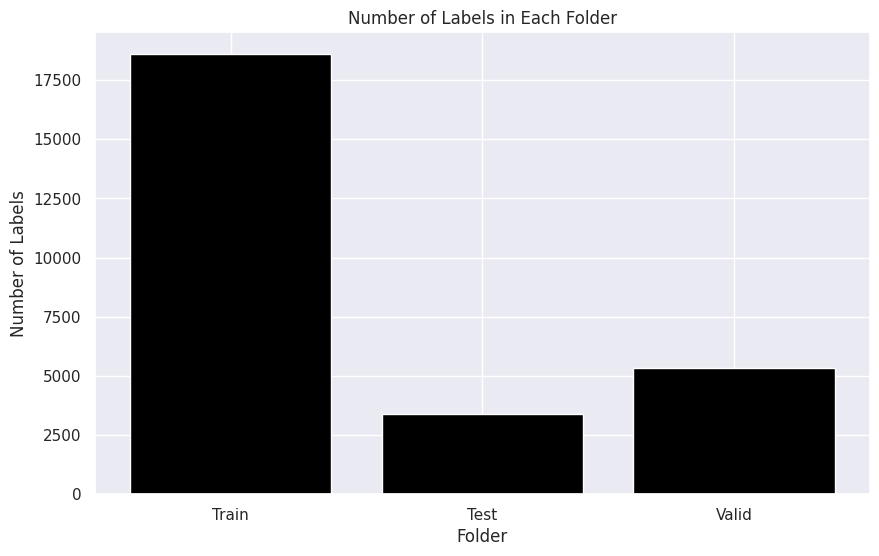

In [13]:
train_folder = '/kaggle/working/duy-data-pbl-4/Data_Lately/train/labels'
test_folder = '/kaggle/working/duy-data-pbl-4/Data_Lately/test/labels'
valid_folder = '/kaggle/working/duy-data-pbl-4/Data_Lately/valid/labels'

# Đếm số lượng ảnh trong mỗi thư mục
train_count = count_images(train_folder)
test_count = count_images(test_folder)
valid_count = count_images(valid_folder)

# Dữ liệu để vẽ biểu đồ
folders = ['Train', 'Test', 'Valid']
image_counts = [train_count, test_count, valid_count]

# Tạo biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(folders, image_counts, color= "black")
plt.xlabel('Folder')
plt.ylabel('Number of Labels')
plt.title('Number of Labels in Each Folder')
plt.show()

In [17]:
Image_dir = '/kaggle/working/duy-data-pbl-4/Data_Lately/train/images'

num_samples = 9
image_files = os.listdir(Image_dir)

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### **Pre-train**

In [18]:
model = YOLO('/kaggle/input/model-ver3/Model_ver3.pt')

In [ ]:
Result_Final_model = model.train(
    data="/kaggle/working/duy-data-pbl-4/Data_Lately/data.yaml",
    epochs=100,
    imgsz=416,
    batch=64,
    lr0=0.0001,
    dropout=0.15,
    device=0,
    augment=True  # Enable data augmentation
)


Ultralytics YOLOv8.2.30 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/model-ver3/Model_ver3.pt, data=/kaggle/working/duy-data-pbl-4/Data_Lately/data.yaml, epochs=100, time=None, patience=100, batch=64, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.15, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False

100%|██████████| 755k/755k [00:00<00:00, 4.32MB/s]
2024-06-10 06:51:42,580	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-10 06:51:43,476	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 24.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/duy-data-pbl-4/Data_Lately/train/labels... 18594 images, 24 backgrounds, 0 corrupt: 100%|██████████| 18594/18594 [00:14<00:00, 1254.93it/s]


train: New cache created: /kaggle/working/duy-data-pbl-4/Data_Lately/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/duy-data-pbl-4/Data_Lately/valid/labels... 5340 images, 1 backgrounds, 0 corrupt: 100%|██████████| 5340/5340 [00:04<00:00, 1140.32it/s]


val: New cache created: /kaggle/working/duy-data-pbl-4/Data_Lately/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.52G      1.062      1.419      1.309         68        416: 100%|██████████| 291/291 [01:31<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.02it/s]

                   all       5340       5800       0.73      0.662      0.732      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.43G     0.7638      1.045      1.064         69        416: 100%|██████████| 291/291 [01:30<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.07it/s]

                   all       5340       5800      0.716      0.624       0.69      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.48G       0.79      1.103      1.072         81        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.04it/s]


                   all       5340       5800       0.32       0.34      0.272      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.46G     0.8096      1.163      1.079         76        416: 100%|██████████| 291/291 [01:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.09it/s]

                   all       5340       5800      0.698      0.602      0.665      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       3.5G     0.7595      1.076      1.058         75        416: 100%|██████████| 291/291 [01:28<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.09it/s]

                   all       5340       5800      0.691      0.645      0.694      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.43G     0.7214      1.012      1.041         78        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.09it/s]


                   all       5340       5800      0.791      0.731      0.785      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.49G     0.6988     0.9607      1.029         86        416: 100%|██████████| 291/291 [01:29<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.04it/s]

                   all       5340       5800      0.814      0.751      0.819      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.43G     0.6792      0.923       1.02         87        416: 100%|██████████| 291/291 [01:30<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]

                   all       5340       5800      0.805      0.782      0.834      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.49G     0.6622     0.9047      1.016         80        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.07it/s]

                   all       5340       5800      0.857      0.779      0.852      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.49G     0.6502     0.8752      1.009         81        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]

                   all       5340       5800      0.862      0.803      0.863      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.43G     0.6375     0.8483      1.007         80        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]

                   all       5340       5800      0.889      0.774      0.864      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.43G     0.6338     0.8346      1.004         84        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]

                   all       5340       5800      0.849      0.792      0.859      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.49G     0.6173     0.8058     0.9973         84        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]

                   all       5340       5800        0.9      0.803      0.878      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.49G     0.6119     0.7972     0.9923         72        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.09it/s]

                   all       5340       5800      0.872      0.823      0.879      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.43G     0.6079     0.7912     0.9922         79        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]

                   all       5340       5800      0.902      0.807      0.882      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.43G     0.5999      0.773     0.9895         82        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.10it/s]

                   all       5340       5800      0.903       0.83      0.899      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.43G     0.5951     0.7578     0.9867         71        416: 100%|██████████| 291/291 [01:29<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]

                   all       5340       5800      0.914      0.813       0.89      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.43G     0.5894     0.7544     0.9861         79        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.10it/s]

                   all       5340       5800      0.917      0.831      0.902      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.43G     0.5832     0.7401     0.9831         96        416: 100%|██████████| 291/291 [01:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]

                   all       5340       5800      0.928      0.828      0.905      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.43G     0.5809      0.735     0.9815         69        416: 100%|██████████| 291/291 [01:29<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]

                   all       5340       5800      0.931      0.832      0.908      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.43G     0.5755     0.7223     0.9786         84        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]

                   all       5340       5800      0.928      0.849      0.912      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.43G     0.5715     0.7107     0.9773         73        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]

                   all       5340       5800       0.93      0.866      0.916      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.43G     0.5649     0.7046     0.9744         87        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.09it/s]

                   all       5340       5800      0.934      0.862      0.922      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.43G     0.5601     0.6926     0.9733         73        416: 100%|██████████| 291/291 [01:28<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]

                   all       5340       5800      0.948       0.85      0.923      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.43G     0.5591      0.688     0.9726         64        416: 100%|██████████| 291/291 [01:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]

                   all       5340       5800      0.935      0.863      0.921        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.43G     0.5511     0.6834     0.9684         74        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]

                   all       5340       5800      0.928      0.862      0.922      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.43G     0.5532     0.6739     0.9694         94        416: 100%|██████████| 291/291 [01:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]

                   all       5340       5800      0.941      0.866      0.926      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.49G     0.5512     0.6653     0.9704         79        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.07it/s]

                   all       5340       5800      0.945      0.863      0.928      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.49G     0.5465     0.6646     0.9694         86        416: 100%|██████████| 291/291 [01:28<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]

                   all       5340       5800      0.946      0.868       0.93      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.43G     0.5423     0.6518     0.9651         91        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.10it/s]

                   all       5340       5800      0.946      0.873      0.931      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.43G      0.542     0.6551      0.967         82        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]

                   all       5340       5800       0.93       0.88      0.933      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.43G     0.5366     0.6501      0.965         79        416: 100%|██████████| 291/291 [01:29<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]

                   all       5340       5800      0.947      0.865      0.933      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.42G     0.5373     0.6411     0.9628         77        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.10it/s]

                   all       5340       5800       0.94      0.875      0.932      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.48G     0.5332     0.6391     0.9606         83        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]

                   all       5340       5800      0.944      0.878      0.934      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.42G     0.5286     0.6311     0.9604         78        416: 100%|██████████| 291/291 [01:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.10it/s]

                   all       5340       5800      0.946      0.881      0.937      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.42G     0.5275     0.6203     0.9602         80        416: 100%|██████████| 291/291 [01:28<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.06it/s]

                   all       5340       5800       0.95      0.881      0.939      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.42G     0.5242     0.6179     0.9587         81        416: 100%|██████████| 291/291 [01:30<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.09it/s]

                   all       5340       5800      0.949      0.882       0.94      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.42G     0.5235     0.6187     0.9586         87        416: 100%|██████████| 291/291 [01:28<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]

                   all       5340       5800       0.94      0.891      0.939      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.42G     0.5229     0.6135     0.9571         84        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]

                   all       5340       5800      0.955      0.883      0.941      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.42G     0.5164     0.6051      0.957         72        416: 100%|██████████| 291/291 [01:28<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.09it/s]

                   all       5340       5800      0.944      0.895      0.941       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.42G      0.515     0.5945     0.9542         69        416: 100%|██████████| 291/291 [01:28<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]

                   all       5340       5800      0.953      0.889      0.942      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.42G     0.5143     0.5957     0.9538         73        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]

                   all       5340       5800      0.941      0.898      0.943      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.42G     0.5124     0.5881     0.9539         92        416: 100%|██████████| 291/291 [01:28<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]

                   all       5340       5800      0.951       0.89      0.941      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.42G     0.5083     0.5796     0.9512         74        416: 100%|██████████| 291/291 [01:28<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]

                   all       5340       5800       0.95      0.892      0.942      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.42G     0.5098     0.5826     0.9515         76        416: 100%|██████████| 291/291 [01:28<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]

                   all       5340       5800       0.95      0.893      0.943      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.42G     0.5024      0.572     0.9507         71        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]

                   all       5340       5800      0.951      0.896      0.943      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.42G     0.5033      0.577     0.9492         69        416: 100%|██████████| 291/291 [01:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]

                   all       5340       5800      0.951      0.897      0.944      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.42G     0.4992     0.5659     0.9493         77        416: 100%|██████████| 291/291 [01:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]

                   all       5340       5800      0.951      0.901      0.945      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.42G     0.4956     0.5658     0.9468         66        416: 100%|██████████| 291/291 [01:28<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]

                   all       5340       5800      0.953        0.9      0.945      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.42G     0.4958     0.5562     0.9466         78        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]

                   all       5340       5800      0.957        0.9      0.946      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.42G     0.4938     0.5566     0.9469         76        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]

                   all       5340       5800      0.956      0.899      0.947      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.42G     0.4888     0.5507     0.9451         82        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:20<00:00,  2.09it/s]

                   all       5340       5800      0.955      0.902      0.947       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.42G       0.49     0.5484     0.9457         76        416: 100%|██████████| 291/291 [01:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]

                   all       5340       5800       0.96      0.898      0.947       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.42G     0.4877     0.5468     0.9446         79        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]

                   all       5340       5800      0.958      0.902      0.948      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.42G     0.4848     0.5395      0.943         70        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]

                   all       5340       5800      0.952      0.905      0.948      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.42G     0.4827     0.5346     0.9422         62        416: 100%|██████████| 291/291 [01:29<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]

                   all       5340       5800      0.955      0.903      0.947      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.42G     0.4813     0.5298     0.9422         71        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]

                   all       5340       5800      0.957        0.9      0.947      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.42G     0.4812      0.527     0.9429        101        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]

                   all       5340       5800      0.958      0.899      0.948      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.42G     0.4778     0.5243     0.9409         80        416: 100%|██████████| 291/291 [01:29<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]

                   all       5340       5800       0.95      0.906      0.948      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.42G      0.476     0.5244     0.9405         88        416: 100%|██████████| 291/291 [01:28<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]

                   all       5340       5800      0.952      0.904      0.948      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.42G     0.4759     0.5151     0.9406         77        416: 100%|██████████| 291/291 [01:28<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]

                   all       5340       5800      0.958      0.898      0.949      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.42G     0.4719     0.5109     0.9397         85        416: 100%|██████████| 291/291 [01:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]

                   all       5340       5800      0.957        0.9      0.949      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.42G     0.4738     0.5133     0.9382         75        416: 100%|██████████| 291/291 [01:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]

                   all       5340       5800      0.954      0.904      0.949      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.42G     0.4655     0.5025     0.9371         77        416: 100%|██████████| 291/291 [01:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]

                   all       5340       5800      0.954      0.904      0.949      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.48G     0.4634      0.501     0.9363         65        416: 100%|██████████| 291/291 [01:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]

                   all       5340       5800      0.957      0.902      0.949      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.42G     0.4629     0.4925     0.9343         77        416: 100%|██████████| 291/291 [01:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]

                   all       5340       5800      0.958      0.901      0.949      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.42G     0.4607     0.4936     0.9344         88        416: 100%|██████████| 291/291 [01:28<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]

                   all       5340       5800       0.96        0.9      0.949      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.42G     0.4586       0.49     0.9346         80        416: 100%|██████████| 291/291 [01:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]

                   all       5340       5800       0.96        0.9      0.949      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.42G      0.462     0.4882     0.9361         77        416: 100%|██████████| 291/291 [01:28<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]

                   all       5340       5800       0.96        0.9      0.949      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.42G     0.4535     0.4838     0.9315         78        416: 100%|██████████| 291/291 [01:28<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]

                   all       5340       5800      0.962      0.899      0.949      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.48G     0.4501     0.4757     0.9315         77        416: 100%|██████████| 291/291 [01:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]

                   all       5340       5800      0.962        0.9       0.95      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.42G      0.452     0.4768     0.9316         68        416: 100%|██████████| 291/291 [01:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]

                   all       5340       5800      0.963        0.9       0.95      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.42G     0.4506     0.4743     0.9315         61        416: 100%|██████████| 291/291 [01:28<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]

                   all       5340       5800      0.964        0.9       0.95      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.42G     0.4493     0.4712     0.9297         75        416: 100%|██████████| 291/291 [01:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]

                   all       5340       5800      0.964        0.9       0.95      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.42G     0.4456     0.4685     0.9322         74        416: 100%|██████████| 291/291 [01:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]

                   all       5340       5800      0.964        0.9       0.95      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.48G     0.4442     0.4594     0.9291         69        416: 100%|██████████| 291/291 [01:27<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]

                   all       5340       5800      0.964        0.9       0.95      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.42G     0.4361     0.4543     0.9277         86        416: 100%|██████████| 291/291 [01:28<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.21it/s]

                   all       5340       5800      0.965      0.901       0.95      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.42G     0.4401     0.4544     0.9286         76        416: 100%|██████████| 291/291 [01:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]

                   all       5340       5800       0.96      0.904       0.95      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.42G     0.4381     0.4524     0.9286         69        416: 100%|██████████| 291/291 [01:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]

                   all       5340       5800       0.96      0.904       0.95      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.42G     0.4345     0.4466     0.9261         65        416: 100%|██████████| 291/291 [01:27<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.21it/s]

                   all       5340       5800      0.957      0.908       0.95      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.42G     0.4317      0.438     0.9246         66        416: 100%|██████████| 291/291 [01:27<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]

                   all       5340       5800      0.957      0.909       0.95      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.48G     0.4289      0.435     0.9262         95        416: 100%|██████████| 291/291 [01:27<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]

                   all       5340       5800      0.957      0.908       0.95      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.48G     0.4252     0.4317     0.9236         77        416: 100%|██████████| 291/291 [01:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:18<00:00,  2.21it/s]

                   all       5340       5800      0.958      0.909       0.95      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.42G     0.4242     0.4257     0.9238         81        416: 100%|██████████| 291/291 [01:27<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]

                   all       5340       5800      0.958      0.909       0.95      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.42G     0.4221     0.4236     0.9236         65        416: 100%|██████████| 291/291 [01:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]

                   all       5340       5800      0.958      0.909       0.95      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.48G     0.4197     0.4211     0.9209         89        416: 100%|██████████| 291/291 [01:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]

                   all       5340       5800      0.958      0.909      0.951      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.42G     0.4197     0.4169     0.9204         85        416: 100%|██████████| 291/291 [01:27<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]

                   all       5340       5800      0.959      0.909      0.951      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.42G     0.4138     0.4143     0.9197         78        416: 100%|██████████| 291/291 [01:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]

                   all       5340       5800       0.96      0.908      0.951      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.42G     0.4132     0.4115     0.9202         90        416: 100%|██████████| 291/291 [01:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]

                   all       5340       5800      0.959       0.91      0.951      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.42G     0.4103     0.4072     0.9185         75        416: 100%|██████████| 291/291 [01:28<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 13/42 [00:06<00:13,  2.20it/s]

In [ ]:
model.save('/kaggle/working/best_model_weights.pt')